In [74]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import random
import torch.nn as nn
from dataset import Thyroid_Dataset
from model import Eff_Unet
from HarDMSEG import HarDMSEG
from loss_metric import DiceLoss, IOU_score, StructureLoss
from LightMed.model.LightMed import LightMed
from PMFSNet.lib.models.PMFSNet import PMFSNet
from PMFSNet.lib.models.PMFSNet_FFT import PMFSNet_FFT
from hybrid_model_v3 import HybridSegModel

In [75]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [76]:
import wandb
wandb.login()

True

In [102]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms.functional as tx
import random
import cv2
from PIL import ImageEnhance
from skimage.exposure import match_histograms
import torchvision.transforms as T
import torchvision.transforms.functional as F
class GE_Thyroid_Dataset(Dataset):
    def __init__(self, csv_file, transform, image_size):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.image_size = image_size
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_name = self.df["image_name"][idx]
        mask_name = self.df["mask_name"][idx]
        image_type = self.df["image_type"][idx]

        if image_type == "train":
            from_folder = "../ge_data/train"
        else:
            from_folder = "../ge_data/test"
        
        image_path = f"{from_folder}/images/{image_name}"
        mask_path = f"{from_folder}/masks/{mask_name}"

        image = Image.open(image_path).convert("L")
        mask = Image.open(mask_path).convert("L")
        
        image_tensor, mask_tensor = self.transform(image, mask, self.image_size)
        mask_tensor = (mask_tensor > 0.5).float()
        if torch.sum(mask_tensor) == 0:
            # print("nothing")
            return [None]
        return image_tensor, mask_tensor, mask_name, image_type

In [103]:
image_size = 128
batch_size = 128
def train_augmentation(image, mask, image_size):
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)

    p = 0.2
    
    # if(random.random() < p):
    #     jitter = T.ColorJitter(brightness = 0.5, contrast = 0.25)
    #     image = jitter(image)
    # if(random.random() < p):
    #     transform = T.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
    #     image = transform(image)  # image must be a PIL image
    # if(random.random() < p):
    #     angle = random.uniform(-10, 10)  # 旋轉角度從 ±10 度
    #     translate = (random.uniform(-0.05, 0.05) * image.size[0],
    #                  random.uniform(-0.05, 0.05) * image.size[1])  # 最多平移 ±5%
    #     scale = random.uniform(0.95, 1.05)  # 尺度縮放 ±5%
    #     shear = [random.uniform(-5, 5), random.uniform(-5, 5)]  # 小幅剪切
    
    #     image = F.affine(image, angle=angle, translate=translate, scale=scale, shear=shear)
    #     mask = F.affine(mask, angle=angle, translate=translate, scale=scale, shear=shear)

        
    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    return image_tensor, mask_tensor
def test_augmentation(image, mask, image_size):
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)

    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    return image_tensor, mask_tensor
def custom_collate_fn(batch):
    # print(batch)
    filtered_batch = [item for item in batch if item[0] is not None]
    if len(filtered_batch) == 0:
        return None
    return torch.utils.data.dataloader.default_collate(filtered_batch)
train_dataset = GE_Thyroid_Dataset("../ge_data/train_csv_for_finetune(0.3).csv", transform = train_augmentation, image_size = image_size)
# train_dataset = GE_Thyroid_Dataset("../ge_data/test_csv_for_finetune_all.csv", transform = train_augmentation, image_size = image_size)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, collate_fn=custom_collate_fn)

test_dataset = GE_Thyroid_Dataset("../ge_data/test_csv_for_finetune_all.csv", transform = test_augmentation, image_size = image_size)
# test_dataset = GE_Thyroid_Dataset("../ge_data/train_csv_for_finetune(0.3).csv", transform = test_augmentation, image_size = image_size)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False, collate_fn=custom_collate_fn)

image, mask, mask_name, image_type = next(iter(train_dataloader))

In [104]:
image.shape

torch.Size([116, 1, 128, 128])

In [105]:
print(len(train_dataset), len(test_dataset))

169 112


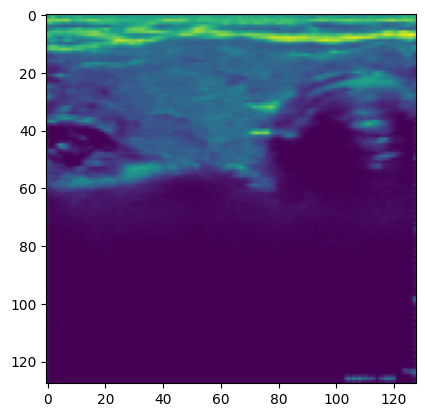

In [106]:
plt.imshow(image[10][0])

In [107]:

# inference_name = "hybrid_v3_baseline"

# model = HybridSegModel(in_channels = 1, out_channels = 2, output_size = image_size, layers_num = 3)
# checkpoint = torch.load(f"models/{inference_name}/best_checkpoint.pth")
# model.load_state_dict(checkpoint['model_state_dict'])
# loss_fn = StructureLoss()
# optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
# lr = 0.01
# model.to("cuda")
# image = image.to("cuda")
# mask = mask.to("cuda")
# for epoch in range(200):
#     outputs = model(image)
        
#     output = outputs[:, 0:1, :, :]
    
    
#     loss = loss_fn(output, mask)

#     IOU = IOU_score(output, mask)

#     dice_loss = DiceLoss()
#     DICE = 1 - dice_loss(output, mask)

    
#     # Backward and optimize
#     optimizer.zero_grad()   # clear previous gradients
#     loss.backward()         # compute gradients
#     optimizer.step()        # update weights
#     print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, IOU: {IOU.item():.4f}, DICE: {DICE.item()}")

In [108]:
def train(dataloader, model, optimizer, loss_fn, device):
    total_loss = 0
    total_IOU = 0
    total_DICE = 0
    
    model.train()
    model.to(device)
    count = 0
    for image, mask, mask_name, image_type in tqdm(dataloader):
        image, mask = image.to(device), mask.to(device)
        
        outputs = model(image)
        
        output = outputs[:, 0:1, :, :]
        
        
        loss = loss_fn(output, mask)

        IOU = IOU_score(output, mask)

        dice_loss = DiceLoss()
        DICE = 1 - dice_loss(output, mask)

        
        # Backward and optimize
        optimizer.zero_grad()   # clear previous gradients
        loss.backward()         # compute gradients
        optimizer.step()        # update weights

        total_loss += loss.item()
        total_IOU += IOU.item()
        total_DICE += DICE.item()
        # count+=1
        # if count==5:
        #     break
    return total_loss/len(dataloader), total_IOU/len(dataloader), total_DICE/len(dataloader)


# 
# Only calculate nodule loss, IOU, DICE, because there is no gland data in the testing set
def val(dataloader, model, loss_fn, device):
    total_loss = 0
    
    total_IOU = 0
    
    total_DICE = 0

    model.eval()
    model.to(device)
    for image, mask, mask_name, image_type in tqdm(dataloader):
        image, mask = image.to(device), mask.to(device)
        outputs = model(image)
        
        output = outputs[:, 0:1, :, :]
        
        
        loss = loss_fn(output, mask)

        IOU = IOU_score(output, mask)

        dice_loss = DiceLoss()
        DICE = 1 - dice_loss(output, mask)
    

        total_loss += loss.item()
        
        total_IOU += IOU.item()
        
        total_DICE += DICE.item()
    return total_loss/len(dataloader), total_IOU/len(dataloader), total_DICE/len(dataloader)


    

In [109]:

inference_name = "hybrid_v3_baseline"

model = HybridSegModel(in_channels = 1, out_channels = 2, output_size = image_size, layers_num = 3)
checkpoint = torch.load(f"models/{inference_name}/best_checkpoint.pth")
model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

<All keys matched successfully>

In [110]:
# freeze encoder
for param in model.backbone.parameters():
    param.requires_grad = False

In [111]:

epochs = 200
lr = 0.01
loss_fn = StructureLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [112]:

project = "thyroid_ge_finetune"
name = "hybrid_model_baseline(0.3)_freeze_encoder_wo_zeromask"
# name = "test"
wandb.init(
    project = project,  # Project name in W&B
    name = name,       # (optional) specific run name
    config={                     # (optional) hyperparameters
        "image_size": image_size,
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": batch_size,
        # "weight_decay":1e-4
    }
)

Learning Rate,██████████▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train_DICE,▁▄▆▇▇▇▇▇▇▇█▇████████████████████████████
train_IOU,▁▄▆▆▆▆▆▆▆▆▇▇▇▇▆▇▇▇██████████████████████
train_loss,█▅▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_DICE,▁██▇▇▇▇▇▇▅▄▅▄▅▅▅▅▄▄▅▄▃▃▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
val_IOU,▁▆▆▇▇▇██████▆▇▇▆▆▆▆▆▆▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
val_loss,▇█▁▁▁▁▁▁▁▁▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃
Learning Rate,0.00018
epoch,182
train_DICE,0.95569


In [113]:
print(f"image size : {image_size}, lr : {lr}, epochs : {epochs}, batch size : {batch_size}")

image size : 128, lr : 0.01, epochs : 200, batch size : 128


In [ ]:
max_IOU = -1
for epoch in range(epochs):
    print(f"epoch : {epoch}")
    total_loss_train, total_IOU_train, total_DICE_train = train(train_dataloader, model, optimizer, loss_fn, "cuda")
    print(f"train loss : {total_loss_train}, train IOU : {total_IOU_train}, train DICE : {total_DICE_train}")
    total_loss_val, total_IOU_val, total_DICE_val = val(test_dataloader, model, loss_fn, "cuda")
    print(f"val loss : {total_loss_val}, val IOU : {total_IOU_val}, val DICE : {total_DICE_val}")
    
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]



    if max_IOU < total_IOU_val:
        max_IOU = total_IOU_val
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            "IOU" : total_IOU_val,
            "DICE" : total_DICE_val,
            "loss" : total_loss_val
        }
        folder = f"models/{name}"
        if not os.path.exists(folder):
            os.mkdir(folder)
        torch.save(checkpoint, f"models/{name}/best_checkpoint.pth")

    
    wandb.log({
        "epoch": epoch,
        "Learning Rate":current_lr,
        
        "train_loss": total_loss_train,
        "train_IOU": total_IOU_train,
        "train_DICE": total_DICE_train,
        
        "val_loss": total_loss_val,
        "val_IOU": total_IOU_val,
        "val_DICE": total_DICE_val,
        
    })




checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    "IOU" : total_IOU_val,
    "DICE" : total_DICE_val,
    "loss" : total_loss_val
}
if not os.path.exists(folder):
    os.mkdir(folder)
torch.save(checkpoint, f"models/{name}/last_checkpoint.pth")
wandb.finish()

epoch : 0


/home/twszbak764/miniconda3/envs/thyroid/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 1.4412735104560852, train IOU : 0.3113172594457865, train DICE : 0.41973817348480225


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 1.4245389699935913, val IOU : 0.08895700424909592, val DICE : 0.16134262084960938
epoch : 1


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.9238567352294922, train IOU : 0.2420782819390297, train DICE : 0.3282073140144348


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.8965522050857544, val IOU : 0.30332908034324646, val DICE : 0.4249250888824463
epoch : 2


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.876183956861496, train IOU : 0.27902115881443024, train DICE : 0.36347153782844543


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.7038209438323975, val IOU : 0.4379984736442566, val DICE : 0.5575934648513794
epoch : 3


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.6322519481182098, train IOU : 0.429428368806839, train DICE : 0.5106596052646637


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.5220128893852234, val IOU : 0.5953084826469421, val DICE : 0.6825424432754517
epoch : 4


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.5324741899967194, train IOU : 0.5609076619148254, train DICE : 0.6327209770679474


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.4810388386249542, val IOU : 0.6458245515823364, val DICE : 0.7391377687454224
epoch : 5


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.5428673923015594, train IOU : 0.5711908638477325, train DICE : 0.641254723072052


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.46199294924736023, val IOU : 0.6567481160163879, val DICE : 0.7453439831733704
epoch : 6


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.5185995399951935, train IOU : 0.5661681592464447, train DICE : 0.6518281996250153


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.45122602581977844, val IOU : 0.6589935421943665, val DICE : 0.737714409828186
epoch : 7


100%|██████████| 2/2 [00:01<00:00,  1.14it/s]


train loss : 0.49225760996341705, train IOU : 0.5629176199436188, train DICE : 0.6655472815036774


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.42817333340644836, val IOU : 0.677822470664978, val DICE : 0.7578607201576233
epoch : 8


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.43637987971305847, train IOU : 0.6056206226348877, train DICE : 0.7202057540416718


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.4019121825695038, val IOU : 0.7109419703483582, val DICE : 0.8036642670631409
epoch : 9


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


train loss : 0.4240715652704239, train IOU : 0.6393008828163147, train DICE : 0.7534314095973969


100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


val loss : 0.39208030700683594, val IOU : 0.7120288014411926, val DICE : 0.806077778339386
epoch : 10


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


train loss : 0.4189537912607193, train IOU : 0.6048743426799774, train DICE : 0.7434236705303192


100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


val loss : 0.3891388475894928, val IOU : 0.708040177822113, val DICE : 0.7976036071777344
epoch : 11


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


train loss : 0.42652076482772827, train IOU : 0.6057330667972565, train DICE : 0.7494029700756073


100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


val loss : 0.38600021600723267, val IOU : 0.7127169370651245, val DICE : 0.8010972142219543
epoch : 12


100%|██████████| 2/2 [00:01<00:00,  1.14it/s]


train loss : 0.4153982847929001, train IOU : 0.6134839951992035, train DICE : 0.7416467070579529


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.3885442018508911, val IOU : 0.7170708179473877, val DICE : 0.8064045310020447
epoch : 13


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.3959226608276367, train IOU : 0.6541006863117218, train DICE : 0.7628951668739319


100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


val loss : 0.39531049132347107, val IOU : 0.7166409492492676, val DICE : 0.8062446713447571
epoch : 14


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.3972256928682327, train IOU : 0.6613371968269348, train DICE : 0.7547074258327484


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.39229896664619446, val IOU : 0.7154614329338074, val DICE : 0.7937292456626892
epoch : 15


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.38897067308425903, train IOU : 0.6479800641536713, train DICE : 0.7639338970184326


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.39167067408561707, val IOU : 0.7191568613052368, val DICE : 0.8081005811691284
epoch : 16


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


train loss : 0.40780553221702576, train IOU : 0.6544941663742065, train DICE : 0.7540615797042847


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.38294076919555664, val IOU : 0.7230117321014404, val DICE : 0.8112836480140686
epoch : 17


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


train loss : 0.39133420586586, train IOU : 0.6594958305358887, train DICE : 0.7697681784629822


100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


val loss : 0.3826068639755249, val IOU : 0.7190356850624084, val DICE : 0.7957999110221863
epoch : 18


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.3868844509124756, train IOU : 0.6517246961593628, train DICE : 0.7505059838294983


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.37592142820358276, val IOU : 0.7244689464569092, val DICE : 0.8127415180206299
epoch : 19


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


train loss : 0.3867098391056061, train IOU : 0.6720869839191437, train DICE : 0.778344452381134


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.3803272843360901, val IOU : 0.7265302538871765, val DICE : 0.8185361623764038
epoch : 20


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


train loss : 0.3655796945095062, train IOU : 0.6799195408821106, train DICE : 0.7853524386882782


100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


val loss : 0.3770657181739807, val IOU : 0.7217057347297668, val DICE : 0.8019240498542786
epoch : 21


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.3672902137041092, train IOU : 0.6609139442443848, train DICE : 0.778814971446991


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.3752973973751068, val IOU : 0.7239804863929749, val DICE : 0.81064373254776
epoch : 22


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


train loss : 0.33916421234607697, train IOU : 0.6951552331447601, train DICE : 0.7986950576305389


100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


val loss : 0.3915403187274933, val IOU : 0.721190333366394, val DICE : 0.8180157542228699
epoch : 23


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


train loss : 0.3498886078596115, train IOU : 0.6746743321418762, train DICE : 0.7780753374099731


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.38422924280166626, val IOU : 0.7220498323440552, val DICE : 0.8157246708869934
epoch : 24


100%|██████████| 2/2 [00:01<00:00,  1.14it/s]


train loss : 0.35344693064689636, train IOU : 0.7045463919639587, train DICE : 0.7926779985427856


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.3743520975112915, val IOU : 0.7239499688148499, val DICE : 0.8079538345336914
epoch : 25


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.34207871556282043, train IOU : 0.6811400055885315, train DICE : 0.7880649566650391


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.3703196346759796, val IOU : 0.7257195711135864, val DICE : 0.8096886277198792
epoch : 26


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.34655410051345825, train IOU : 0.6892126202583313, train DICE : 0.7991164028644562


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.3760312497615814, val IOU : 0.7300703525543213, val DICE : 0.8249098062515259
epoch : 27


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


train loss : 0.3280331492424011, train IOU : 0.7088953852653503, train DICE : 0.8070392310619354


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.36310288310050964, val IOU : 0.7299830317497253, val DICE : 0.8148228526115417
epoch : 28


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.33159056305885315, train IOU : 0.6993851065635681, train DICE : 0.7978217005729675


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.3649130165576935, val IOU : 0.7291758060455322, val DICE : 0.8142710328102112
epoch : 29


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.305353581905365, train IOU : 0.7221975922584534, train DICE : 0.8124554455280304


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.3768712282180786, val IOU : 0.728309690952301, val DICE : 0.8205651044845581
epoch : 30


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.29871372878551483, train IOU : 0.7142911851406097, train DICE : 0.816990077495575


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.39051562547683716, val IOU : 0.7222917079925537, val DICE : 0.8199796676635742
epoch : 31


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.2852734699845314, train IOU : 0.7508448958396912, train DICE : 0.8282992839813232


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.36763912439346313, val IOU : 0.730772078037262, val DICE : 0.8191183805465698
epoch : 32


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


train loss : 0.2905690371990204, train IOU : 0.727692037820816, train DICE : 0.8223971128463745


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.36013340950012207, val IOU : 0.7352012991905212, val DICE : 0.8223899006843567
epoch : 33


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


train loss : 0.3002491444349289, train IOU : 0.7409222722053528, train DICE : 0.830141007900238


100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


val loss : 0.3560773730278015, val IOU : 0.7373546361923218, val DICE : 0.8239688277244568
epoch : 34


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.2802972197532654, train IOU : 0.7412225008010864, train DICE : 0.8305669128894806


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.35580769181251526, val IOU : 0.736600935459137, val DICE : 0.8194404244422913
epoch : 35


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.26890457421541214, train IOU : 0.7465166449546814, train DICE : 0.8376604616641998


100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


val loss : 0.38038116693496704, val IOU : 0.7281856536865234, val DICE : 0.8251621127128601
epoch : 36


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.2902919799089432, train IOU : 0.7533693313598633, train DICE : 0.8315446376800537


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.3679972290992737, val IOU : 0.7276778817176819, val DICE : 0.8107190728187561
epoch : 37


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


train loss : 0.27462130784988403, train IOU : 0.7269080281257629, train DICE : 0.8201152980327606


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.38868090510368347, val IOU : 0.7263833284378052, val DICE : 0.8238072395324707
epoch : 38


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.2859179824590683, train IOU : 0.7649291753768921, train DICE : 0.8354630470275879


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.3604081869125366, val IOU : 0.7372335195541382, val DICE : 0.8217862248420715
epoch : 39


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.27094705402851105, train IOU : 0.7422544956207275, train DICE : 0.8328262269496918


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.36061355471611023, val IOU : 0.7332011461257935, val DICE : 0.8076288104057312
epoch : 40


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.2685496062040329, train IOU : 0.7493038177490234, train DICE : 0.83290034532547


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.3797042965888977, val IOU : 0.7314560413360596, val DICE : 0.8178185224533081
epoch : 41


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.2545446753501892, train IOU : 0.775848388671875, train DICE : 0.8417144119739532


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.40987515449523926, val IOU : 0.7171210050582886, val DICE : 0.8127708435058594
epoch : 42


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.2521599233150482, train IOU : 0.7852561771869659, train DICE : 0.8562167882919312


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.38676926493644714, val IOU : 0.723630964756012, val DICE : 0.8092707395553589
epoch : 43


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.23859281837940216, train IOU : 0.7733844816684723, train DICE : 0.855311781167984


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.383156955242157, val IOU : 0.7251776456832886, val DICE : 0.8077393770217896
epoch : 44


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.23873082548379898, train IOU : 0.775750070810318, train DICE : 0.8564895391464233


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.40446874499320984, val IOU : 0.7186611294746399, val DICE : 0.8112674355506897
epoch : 45


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.24764439463615417, train IOU : 0.7916342318058014, train DICE : 0.8598599433898926


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.39698341488838196, val IOU : 0.7225090861320496, val DICE : 0.8137645721435547
epoch : 46


100%|██████████| 2/2 [00:01<00:00,  1.14it/s]


train loss : 0.22171711176633835, train IOU : 0.792878270149231, train DICE : 0.8643860816955566


100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


val loss : 0.38433873653411865, val IOU : 0.7256600856781006, val DICE : 0.8130641579627991
epoch : 47


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.2157410904765129, train IOU : 0.7961056530475616, train DICE : 0.8713734745979309


100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


val loss : 0.41064172983169556, val IOU : 0.7156785130500793, val DICE : 0.8138821125030518
epoch : 48


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


train loss : 0.21192551404237747, train IOU : 0.8115743398666382, train DICE : 0.8788577020168304


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.4145873785018921, val IOU : 0.7145269513130188, val DICE : 0.8134247660636902
epoch : 49


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.21613428741693497, train IOU : 0.7894156873226166, train DICE : 0.8680055141448975


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.39772477746009827, val IOU : 0.721621036529541, val DICE : 0.8148351907730103
epoch : 50


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train loss : 0.21170635521411896, train IOU : 0.8125784993171692, train DICE : 0.8766609132289886


100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


val loss : 0.4028550684452057, val IOU : 0.7207978963851929, val DICE : 0.8148549199104309
epoch : 51


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.20701029896736145, train IOU : 0.8177858591079712, train DICE : 0.8836860060691833


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.39877861738204956, val IOU : 0.7209495306015015, val DICE : 0.8146654367446899
epoch : 52


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


train loss : 0.1988365799188614, train IOU : 0.8170992732048035, train DICE : 0.8815025091171265


100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


val loss : 0.41768234968185425, val IOU : 0.7127436399459839, val DICE : 0.8133838772773743
epoch : 53


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


train loss : 0.20632333308458328, train IOU : 0.8234048783779144, train DICE : 0.8825663030147552


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.4110151529312134, val IOU : 0.7155632972717285, val DICE : 0.8160926103591919
epoch : 54


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


train loss : 0.20114199072122574, train IOU : 0.8217918574810028, train DICE : 0.8819370865821838


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.38870200514793396, val IOU : 0.72276771068573, val DICE : 0.8177660703659058
epoch : 55


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.1921769604086876, train IOU : 0.8293877243995667, train DICE : 0.8893031179904938


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.393559068441391, val IOU : 0.7236625552177429, val DICE : 0.8207868933677673
epoch : 56


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.1861397922039032, train IOU : 0.8328036069869995, train DICE : 0.8934916853904724


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


val loss : 0.4024142622947693, val IOU : 0.7208733558654785, val DICE : 0.8224204182624817
epoch : 57


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


train loss : 0.188674196600914, train IOU : 0.8369847238063812, train DICE : 0.8987634778022766


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.3881303071975708, val IOU : 0.7241957187652588, val DICE : 0.8218873143196106
epoch : 58


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.1848350167274475, train IOU : 0.8201120495796204, train DICE : 0.8899275362491608


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.39902663230895996, val IOU : 0.7225539684295654, val DICE : 0.8241145610809326
epoch : 59


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.18024462461471558, train IOU : 0.8446007072925568, train DICE : 0.9010971486568451


100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


val loss : 0.39646315574645996, val IOU : 0.7254607677459717, val DICE : 0.8248611688613892
epoch : 60


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


train loss : 0.17111928761005402, train IOU : 0.847220242023468, train DICE : 0.9027900695800781


100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


val loss : 0.3837261199951172, val IOU : 0.7264748811721802, val DICE : 0.8197450041770935
epoch : 61


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.17286153882741928, train IOU : 0.831672728061676, train DICE : 0.8964362144470215


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.4268955886363983, val IOU : 0.7098861336708069, val DICE : 0.8139184713363647
epoch : 62


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.17224997282028198, train IOU : 0.8560054302215576, train DICE : 0.9092817604541779


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.4249304234981537, val IOU : 0.7106857299804688, val DICE : 0.8143481016159058
epoch : 63


100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


train loss : 0.16774193942546844, train IOU : 0.840084969997406, train DICE : 0.9034729599952698


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.39434561133384705, val IOU : 0.7209578156471252, val DICE : 0.8178677558898926
epoch : 64


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.16212089359760284, train IOU : 0.8432742059230804, train DICE : 0.9043512046337128


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.4190275967121124, val IOU : 0.7172896265983582, val DICE : 0.8189737200737
epoch : 65


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.16595777869224548, train IOU : 0.8617645502090454, train DICE : 0.9070195853710175


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.411428302526474, val IOU : 0.7177311182022095, val DICE : 0.8184411525726318
epoch : 66


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.15655524283647537, train IOU : 0.8553568124771118, train DICE : 0.9117794334888458


100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


val loss : 0.4104178249835968, val IOU : 0.7126241326332092, val DICE : 0.8135215044021606
epoch : 67


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.1520254909992218, train IOU : 0.8584069609642029, train DICE : 0.909815788269043


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.4393567442893982, val IOU : 0.7020972371101379, val DICE : 0.8114237189292908
epoch : 68


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.15203745663166046, train IOU : 0.8705406486988068, train DICE : 0.9189063012599945


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.4102660119533539, val IOU : 0.7187063097953796, val DICE : 0.8208026885986328
epoch : 69


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.15200943499803543, train IOU : 0.8539006412029266, train DICE : 0.9134623110294342


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.3888671100139618, val IOU : 0.7266891002655029, val DICE : 0.8249678611755371
epoch : 70


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.14566614478826523, train IOU : 0.8703702986240387, train DICE : 0.9196192920207977


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.4069724380970001, val IOU : 0.7225351333618164, val DICE : 0.8241020441055298
epoch : 71


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.14302361756563187, train IOU : 0.8781015872955322, train DICE : 0.9219630062580109


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.4128236472606659, val IOU : 0.717477023601532, val DICE : 0.8212311863899231
epoch : 72


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.13448923081159592, train IOU : 0.8803796172142029, train DICE : 0.9263558685779572


100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


val loss : 0.41396307945251465, val IOU : 0.7162989377975464, val DICE : 0.8196406960487366
epoch : 73


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.14203469455242157, train IOU : 0.8812384903430939, train DICE : 0.9255777597427368


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.41085776686668396, val IOU : 0.7185604572296143, val DICE : 0.8198358416557312
epoch : 74


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


train loss : 0.13601423054933548, train IOU : 0.8751959800720215, train DICE : 0.9254395365715027


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.4169650673866272, val IOU : 0.7169972658157349, val DICE : 0.8181362152099609
epoch : 75


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


train loss : 0.13325615227222443, train IOU : 0.8816429078578949, train DICE : 0.927699863910675


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.4466319680213928, val IOU : 0.7039964199066162, val DICE : 0.8098673820495605
epoch : 76


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


train loss : 0.13069020956754684, train IOU : 0.880931943655014, train DICE : 0.9282924830913544


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.45037516951560974, val IOU : 0.6999466419219971, val DICE : 0.8069853782653809
epoch : 77


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.12933079153299332, train IOU : 0.8867882192134857, train DICE : 0.9305935204029083


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.4478650987148285, val IOU : 0.7010424733161926, val DICE : 0.8091858625411987
epoch : 78


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.12834706157445908, train IOU : 0.8821868598461151, train DICE : 0.9302721619606018


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.43106627464294434, val IOU : 0.7109329104423523, val DICE : 0.8173971772193909
epoch : 79


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


train loss : 0.13209105283021927, train IOU : 0.8887754678726196, train DICE : 0.9306864440441132


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.3990764617919922, val IOU : 0.7250888347625732, val DICE : 0.8254052996635437
epoch : 80


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.12991254031658173, train IOU : 0.8896507024765015, train DICE : 0.932014137506485


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.38913074135780334, val IOU : 0.7275605797767639, val DICE : 0.8270357251167297
epoch : 81


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.13240071386098862, train IOU : 0.881286084651947, train DICE : 0.9298255443572998


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.40394169092178345, val IOU : 0.7248247861862183, val DICE : 0.8274549245834351
epoch : 82


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.12122514843940735, train IOU : 0.8994908928871155, train DICE : 0.9364838302135468


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.42193201184272766, val IOU : 0.7153549790382385, val DICE : 0.8188945651054382
epoch : 83


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


train loss : 0.11792005598545074, train IOU : 0.89007169008255, train DICE : 0.9345073699951172


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.4449067711830139, val IOU : 0.7052451968193054, val DICE : 0.8119977712631226
epoch : 84


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.12226760014891624, train IOU : 0.9003289341926575, train DICE : 0.9386938214302063


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.4241461455821991, val IOU : 0.7152552604675293, val DICE : 0.8172078728675842
epoch : 85


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.11631174758076668, train IOU : 0.8945957124233246, train DICE : 0.9367486834526062


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.4166220724582672, val IOU : 0.717235267162323, val DICE : 0.8194160461425781
epoch : 86


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.111023660749197, train IOU : 0.9011075794696808, train DICE : 0.9409830272197723


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.4484407603740692, val IOU : 0.7039132118225098, val DICE : 0.8133127093315125
epoch : 87


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.11476974189281464, train IOU : 0.896291971206665, train DICE : 0.9388263821601868


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.4243011474609375, val IOU : 0.7121587991714478, val DICE : 0.8171293139457703
epoch : 88


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


train loss : 0.11053235083818436, train IOU : 0.8990820646286011, train DICE : 0.9397124946117401


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.4404909312725067, val IOU : 0.709977388381958, val DICE : 0.8173293471336365
epoch : 89


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.10830823704600334, train IOU : 0.9031649231910706, train DICE : 0.9411833584308624


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.4290165603160858, val IOU : 0.7165717482566833, val DICE : 0.8216032385826111
epoch : 90


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.10912906005978584, train IOU : 0.901038408279419, train DICE : 0.9377941191196442


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.43959841132164, val IOU : 0.7104378938674927, val DICE : 0.8166646361351013
epoch : 91


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.10799733176827431, train IOU : 0.9057281911373138, train DICE : 0.9423997402191162


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.4397004246711731, val IOU : 0.7065631151199341, val DICE : 0.8123827576637268
epoch : 92


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.10633053258061409, train IOU : 0.9036582410335541, train DICE : 0.9422801434993744


100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


val loss : 0.4344300925731659, val IOU : 0.7103945016860962, val DICE : 0.8164523243904114
epoch : 93


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.1076890230178833, train IOU : 0.9103745520114899, train DICE : 0.9442204535007477


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.414495050907135, val IOU : 0.7197239995002747, val DICE : 0.8230335116386414
epoch : 94


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.10278138518333435, train IOU : 0.9033387899398804, train DICE : 0.9444383680820465


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.41639694571495056, val IOU : 0.720759928226471, val DICE : 0.824674129486084
epoch : 95


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.10183040425181389, train IOU : 0.9024704098701477, train DICE : 0.9402894079685211


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.4706275761127472, val IOU : 0.7014608979225159, val DICE : 0.8134041428565979
epoch : 96


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


train loss : 0.10735275596380234, train IOU : 0.911956250667572, train DICE : 0.9475655555725098


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.40774407982826233, val IOU : 0.7188822627067566, val DICE : 0.8212288618087769
epoch : 97


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.10746636241674423, train IOU : 0.8920237720012665, train DICE : 0.9414091408252716


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.414632648229599, val IOU : 0.7218411564826965, val DICE : 0.8240448832511902
epoch : 98


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train loss : 0.10791579633951187, train IOU : 0.911207377910614, train DICE : 0.9439970254898071


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.43588975071907043, val IOU : 0.7121707201004028, val DICE : 0.818310022354126
epoch : 99


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.10168657824397087, train IOU : 0.9051717221736908, train DICE : 0.9448878169059753


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.43605613708496094, val IOU : 0.7045499682426453, val DICE : 0.8129613995552063
epoch : 100


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.10215405002236366, train IOU : 0.9088282883167267, train DICE : 0.9459337592124939


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.4621158540248871, val IOU : 0.6965168118476868, val DICE : 0.8095270395278931
epoch : 101


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.09808126837015152, train IOU : 0.9131670296192169, train DICE : 0.9466173946857452


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.4404486119747162, val IOU : 0.7122118473052979, val DICE : 0.8196675181388855
epoch : 102


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.10034262761473656, train IOU : 0.9179455041885376, train DICE : 0.9485030472278595


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.4141934812068939, val IOU : 0.723623514175415, val DICE : 0.8258272409439087
epoch : 103


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.1007549799978733, train IOU : 0.9135900735855103, train DICE : 0.9483797550201416


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.40828341245651245, val IOU : 0.7222064733505249, val DICE : 0.8237091898918152
epoch : 104


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.09556809440255165, train IOU : 0.9038251340389252, train DICE : 0.9473212361335754


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.4437619149684906, val IOU : 0.7090725898742676, val DICE : 0.8168278336524963
epoch : 105


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.1055653989315033, train IOU : 0.9171102643013, train DICE : 0.9485366344451904


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.43872326612472534, val IOU : 0.7069481611251831, val DICE : 0.8146089911460876
epoch : 106


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.09651121124625206, train IOU : 0.9141216278076172, train DICE : 0.9492938816547394


100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


val loss : 0.42480340600013733, val IOU : 0.7105458974838257, val DICE : 0.8164907693862915
epoch : 107


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


train loss : 0.09558948874473572, train IOU : 0.9119712710380554, train DICE : 0.9480013847351074


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.4613175392150879, val IOU : 0.7049887776374817, val DICE : 0.8153504133224487
epoch : 108


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


train loss : 0.09769102931022644, train IOU : 0.9205144941806793, train DICE : 0.9521670639514923


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.4384593367576599, val IOU : 0.7124130725860596, val DICE : 0.8186057209968567
epoch : 109


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


train loss : 0.09106083959341049, train IOU : 0.9187849462032318, train DICE : 0.9524441063404083


100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


val loss : 0.42371276021003723, val IOU : 0.7131841778755188, val DICE : 0.8174701929092407
epoch : 110


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


train loss : 0.09416282922029495, train IOU : 0.9089908301830292, train DICE : 0.948012501001358


100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


val loss : 0.45851054787635803, val IOU : 0.6998464465141296, val DICE : 0.8095860481262207
epoch : 111


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.08864852041006088, train IOU : 0.9273103475570679, train DICE : 0.9560612142086029


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.46390846371650696, val IOU : 0.6992703080177307, val DICE : 0.8104208111763
epoch : 112


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.09057571738958359, train IOU : 0.929988294839859, train DICE : 0.9553653597831726


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.41889244318008423, val IOU : 0.7151031494140625, val DICE : 0.8211768865585327
epoch : 113


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.09045081213116646, train IOU : 0.9109582304954529, train DICE : 0.9514726996421814


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.41432344913482666, val IOU : 0.7203719615936279, val DICE : 0.8269296884536743
epoch : 114


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.08897924050688744, train IOU : 0.9195723831653595, train DICE : 0.9520970284938812


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.44085004925727844, val IOU : 0.7133417129516602, val DICE : 0.8236324787139893
epoch : 115


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


train loss : 0.08767351135611534, train IOU : 0.9291150867938995, train DICE : 0.9549464881420135


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.43045157194137573, val IOU : 0.7119168639183044, val DICE : 0.8203231692314148
epoch : 116


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.08513201400637627, train IOU : 0.9216170907020569, train DICE : 0.9545729458332062


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.4317595958709717, val IOU : 0.710692822933197, val DICE : 0.8189085125923157
epoch : 117


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


train loss : 0.09604039043188095, train IOU : 0.9245569109916687, train DICE : 0.9521050453186035


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.4328666031360626, val IOU : 0.7123515009880066, val DICE : 0.8201735615730286
epoch : 118


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.08507485315203667, train IOU : 0.92550989985466, train DICE : 0.9563309252262115


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.42453235387802124, val IOU : 0.7161670327186584, val DICE : 0.8220726251602173
epoch : 119


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.0855526551604271, train IOU : 0.9167906939983368, train DICE : 0.9540570974349976


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


val loss : 0.449127197265625, val IOU : 0.7099084854125977, val DICE : 0.8184022903442383
epoch : 120


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


train loss : 0.08641007542610168, train IOU : 0.9318020641803741, train DICE : 0.9576719701290131


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.4594128131866455, val IOU : 0.7035297155380249, val DICE : 0.8140313625335693
epoch : 121


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


train loss : 0.08337117731571198, train IOU : 0.9335700869560242, train DICE : 0.9575065672397614


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.4345438778400421, val IOU : 0.70819091796875, val DICE : 0.8157724738121033
epoch : 122


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.08636857196688652, train IOU : 0.9192634224891663, train DICE : 0.9538620114326477


100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


val loss : 0.44069984555244446, val IOU : 0.7069948315620422, val DICE : 0.8157258629798889
epoch : 123


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.0842193067073822, train IOU : 0.9255450963973999, train DICE : 0.9571104645729065


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.46476736664772034, val IOU : 0.7023849487304688, val DICE : 0.8126549124717712
epoch : 124


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.08228340744972229, train IOU : 0.9347603917121887, train DICE : 0.9591701328754425


100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


val loss : 0.4532496929168701, val IOU : 0.7060922980308533, val DICE : 0.8142532110214233
epoch : 125


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.0813896618783474, train IOU : 0.9292598068714142, train DICE : 0.9576274156570435


100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


val loss : 0.44586408138275146, val IOU : 0.707334578037262, val DICE : 0.8153076767921448
epoch : 126


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.08008909225463867, train IOU : 0.9206509292125702, train DICE : 0.9549344182014465


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.4568111300468445, val IOU : 0.7059018015861511, val DICE : 0.8159699440002441
epoch : 127


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.0825493335723877, train IOU : 0.9353097975254059, train DICE : 0.9594846367835999


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.4465012550354004, val IOU : 0.710081934928894, val DICE : 0.8188064694404602
epoch : 128


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.0790935829281807, train IOU : 0.929656982421875, train DICE : 0.9581118226051331


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.43065062165260315, val IOU : 0.7128093242645264, val DICE : 0.8203541040420532
epoch : 129


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.07842735946178436, train IOU : 0.9291254281997681, train DICE : 0.9587321579456329


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.4449993968009949, val IOU : 0.7093513011932373, val DICE : 0.8189759850502014
epoch : 130


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.07912344858050346, train IOU : 0.9370779097080231, train DICE : 0.9605213105678558


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.45247766375541687, val IOU : 0.70712810754776, val DICE : 0.8176766633987427
epoch : 131


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.0773230716586113, train IOU : 0.9368154108524323, train DICE : 0.9610864222049713


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.4405970275402069, val IOU : 0.7100672721862793, val DICE : 0.8187423348426819
epoch : 132


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.07837041839957237, train IOU : 0.9270735085010529, train DICE : 0.9582913815975189


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val loss : 0.44223904609680176, val IOU : 0.7095472812652588, val DICE : 0.8181565403938293
epoch : 133


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.08571438863873482, train IOU : 0.9291777610778809, train DICE : 0.9573190212249756


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.44835707545280457, val IOU : 0.7084342241287231, val DICE : 0.816991925239563
epoch : 134


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.07714100554585457, train IOU : 0.9296425879001617, train DICE : 0.9602888822555542


100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


val loss : 0.4432421028614044, val IOU : 0.7105125784873962, val DICE : 0.8194333910942078
epoch : 135


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.07906408235430717, train IOU : 0.9246003031730652, train DICE : 0.9565034508705139


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.45472097396850586, val IOU : 0.7083287835121155, val DICE : 0.8194740414619446
epoch : 136


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.07951570302248001, train IOU : 0.9385920464992523, train DICE : 0.961440771818161


100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


val loss : 0.45400470495224, val IOU : 0.7083860039710999, val DICE : 0.8188241124153137
epoch : 137


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.07677363604307175, train IOU : 0.9375983476638794, train DICE : 0.9620124995708466


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.4419872760772705, val IOU : 0.7090781927108765, val DICE : 0.8182264566421509
epoch : 138


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.08115116879343987, train IOU : 0.920654684305191, train DICE : 0.9558039903640747


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.45146167278289795, val IOU : 0.7070436477661133, val DICE : 0.8175894618034363
epoch : 139


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.08356086909770966, train IOU : 0.9313404262065887, train DICE : 0.9592582583427429


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.4576563239097595, val IOU : 0.7058510780334473, val DICE : 0.8168026208877563
epoch : 140


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


train loss : 0.07698848471045494, train IOU : 0.9364066123962402, train DICE : 0.9620296061038971


100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


val loss : 0.4404008984565735, val IOU : 0.709324300289154, val DICE : 0.8181657195091248
epoch : 141


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.0794108472764492, train IOU : 0.9200572371482849, train DICE : 0.9572706818580627


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.4426499009132385, val IOU : 0.709395170211792, val DICE : 0.8182029128074646
epoch : 142


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


train loss : 0.07204705476760864, train IOU : 0.937686562538147, train DICE : 0.9619732201099396


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val loss : 0.46243128180503845, val IOU : 0.7055186629295349, val DICE : 0.8162449598312378
epoch : 143


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.07619563490152359, train IOU : 0.9411149621009827, train DICE : 0.9621848464012146


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.4614591598510742, val IOU : 0.705359697341919, val DICE : 0.8169474601745605
epoch : 144


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.07451123371720314, train IOU : 0.9402925372123718, train DICE : 0.9631533622741699


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.44638490676879883, val IOU : 0.7075778245925903, val DICE : 0.8180590271949768
epoch : 145


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.07553716748952866, train IOU : 0.9303916394710541, train DICE : 0.9603864252567291


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.44211113452911377, val IOU : 0.7093420624732971, val DICE : 0.8194294571876526
epoch : 146


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.07441866025328636, train IOU : 0.9292018115520477, train DICE : 0.9616125524044037


100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


val loss : 0.45236971974372864, val IOU : 0.709877073764801, val DICE : 0.8202816247940063
epoch : 147


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.08112355694174767, train IOU : 0.9366390705108643, train DICE : 0.9620194435119629


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.45620065927505493, val IOU : 0.7088053226470947, val DICE : 0.8187070488929749
epoch : 148


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.07254750281572342, train IOU : 0.9365431666374207, train DICE : 0.96152663230896


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.4477682113647461, val IOU : 0.7075656056404114, val DICE : 0.8173859119415283
epoch : 149


100%|██████████| 2/2 [00:01<00:00,  1.14it/s]


train loss : 0.07253306359052658, train IOU : 0.9368749260902405, train DICE : 0.9627047777175903


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.4555850625038147, val IOU : 0.7052009105682373, val DICE : 0.8154425024986267
epoch : 150


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.07267705351114273, train IOU : 0.9337100982666016, train DICE : 0.962435394525528


100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


val loss : 0.466080904006958, val IOU : 0.7029227018356323, val DICE : 0.8147906064987183
epoch : 151


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.07233640924096107, train IOU : 0.9380015134811401, train DICE : 0.9629874229431152


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.4648917615413666, val IOU : 0.705310046672821, val DICE : 0.8170908689498901
epoch : 152


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.07318157330155373, train IOU : 0.9411107897758484, train DICE : 0.9643381237983704


100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


val loss : 0.45440807938575745, val IOU : 0.7090179324150085, val DICE : 0.8189031481742859
epoch : 153


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.07209443300962448, train IOU : 0.9398178458213806, train DICE : 0.9641146659851074


100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


val loss : 0.4440559446811676, val IOU : 0.7101849913597107, val DICE : 0.8196086287498474
epoch : 154


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.07221445813775063, train IOU : 0.9328862130641937, train DICE : 0.962462842464447


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.4453601539134979, val IOU : 0.7098411321640015, val DICE : 0.8194648027420044
epoch : 155


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.07212702557444572, train IOU : 0.9281949996948242, train DICE : 0.9592179656028748


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.45721879601478577, val IOU : 0.7074766755104065, val DICE : 0.8185371160507202
epoch : 156


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.07467423006892204, train IOU : 0.9428803622722626, train DICE : 0.9641457498073578


100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


val loss : 0.4653104245662689, val IOU : 0.7046992182731628, val DICE : 0.8169738054275513
epoch : 157


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train loss : 0.07170282676815987, train IOU : 0.9428367018699646, train DICE : 0.965117484331131


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.4532729983329773, val IOU : 0.7069194912910461, val DICE : 0.8181368112564087
epoch : 158


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.07012259587645531, train IOU : 0.9371357262134552, train DICE : 0.96326944231987


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.4460263252258301, val IOU : 0.7082290053367615, val DICE : 0.8190256953239441
epoch : 159


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.07182959094643593, train IOU : 0.9330655336380005, train DICE : 0.9626194536685944


100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


val loss : 0.44982925057411194, val IOU : 0.7080184817314148, val DICE : 0.8193221092224121
epoch : 160


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.07600816711783409, train IOU : 0.9386181533336639, train DICE : 0.9625117778778076


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.45769232511520386, val IOU : 0.7064787745475769, val DICE : 0.8184748888015747
epoch : 161


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.07065107300877571, train IOU : 0.9405802190303802, train DICE : 0.9637282490730286


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.45872753858566284, val IOU : 0.7056199312210083, val DICE : 0.8182519674301147
epoch : 162


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.07052178308367729, train IOU : 0.9415755271911621, train DICE : 0.9647466540336609


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val loss : 0.4589219093322754, val IOU : 0.7057738304138184, val DICE : 0.8182108402252197
epoch : 163


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train loss : 0.07188021391630173, train IOU : 0.9410386383533478, train DICE : 0.9642807245254517


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val loss : 0.45694807171821594, val IOU : 0.7063013315200806, val DICE : 0.818332314491272
epoch : 164


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.07144753262400627, train IOU : 0.9404450953006744, train DICE : 0.9640657603740692


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.45401954650878906, val IOU : 0.7078293561935425, val DICE : 0.8187552094459534
epoch : 165


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.07151960581541061, train IOU : 0.939744234085083, train DICE : 0.9633099436759949


100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


val loss : 0.4523404538631439, val IOU : 0.7086402177810669, val DICE : 0.8195762038230896
epoch : 166


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.07018786296248436, train IOU : 0.9342558681964874, train DICE : 0.9612939357757568


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.4536404013633728, val IOU : 0.7094220519065857, val DICE : 0.8202801942825317
epoch : 167


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


train loss : 0.06984168663620949, train IOU : 0.9410086572170258, train DICE : 0.9635292887687683


100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


val loss : 0.4592597186565399, val IOU : 0.7084097266197205, val DICE : 0.8198631405830383
epoch : 168


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.07032683119177818, train IOU : 0.943584144115448, train DICE : 0.9645109474658966


100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


val loss : 0.46106255054473877, val IOU : 0.7076455354690552, val DICE : 0.8194120526313782
epoch : 169


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.07076606154441833, train IOU : 0.9456600546836853, train DICE : 0.9651855826377869


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.45991259813308716, val IOU : 0.7071046829223633, val DICE : 0.8185275793075562
epoch : 170


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.07090698927640915, train IOU : 0.935495913028717, train DICE : 0.9615014493465424


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.45534560084342957, val IOU : 0.706846296787262, val DICE : 0.8186959624290466
epoch : 171


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


train loss : 0.06906120106577873, train IOU : 0.9423465132713318, train DICE : 0.9653445780277252


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.45540836453437805, val IOU : 0.7061709761619568, val DICE : 0.8179842233657837
epoch : 172


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


train loss : 0.0690414346754551, train IOU : 0.9359967708587646, train DICE : 0.9635255038738251


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.4549737572669983, val IOU : 0.7064122557640076, val DICE : 0.8182899355888367
epoch : 173


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


train loss : 0.0693146325647831, train IOU : 0.9416792094707489, train DICE : 0.9648117125034332


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.4576435089111328, val IOU : 0.7061663269996643, val DICE : 0.8182666897773743
epoch : 174


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.06950346007943153, train IOU : 0.945526123046875, train DICE : 0.964861273765564


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.45835360884666443, val IOU : 0.706342875957489, val DICE : 0.8185471892356873
epoch : 175


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train loss : 0.06865142658352852, train IOU : 0.9411740303039551, train DICE : 0.9646908342838287


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.45635923743247986, val IOU : 0.7071001529693604, val DICE : 0.8194359540939331
epoch : 176


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


train loss : 0.0683605708181858, train IOU : 0.9442420899868011, train DICE : 0.9653742015361786


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.45655980706214905, val IOU : 0.7069985270500183, val DICE : 0.819344699382782
epoch : 177


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train loss : 0.06815839931368828, train IOU : 0.9455172419548035, train DICE : 0.965423971414566


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val loss : 0.45654478669166565, val IOU : 0.707073450088501, val DICE : 0.8192000389099121
epoch : 178


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.06848638132214546, train IOU : 0.94385626912117, train DICE : 0.9655457437038422


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val loss : 0.4573932886123657, val IOU : 0.7067440152168274, val DICE : 0.8186632394790649
epoch : 179


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train loss : 0.0722220130264759, train IOU : 0.9411217570304871, train DICE : 0.9646919965744019


  0%|          | 0/1 [00:00<?, ?it/s]

In [42]:
inference_name = "hybrid_model_baseline(0.3)_freeze_encoder"
model = HybridSegModel(in_channels = 1, out_channels = 2, output_size = image_size, layers_num = 3)
checkpoint = torch.load(f"models/{inference_name}/best_checkpoint.pth")
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
# image, mask, seg_type, from_dataset = next(iter(test_dataloader))
# model.to("cpu")
# outputs = model(image)
# print(outputs.shape)

In [ ]:
# index = 20
# plt.subplot(1,2,1)
# plt.imshow(image[index][0])
# plt.imshow(mask[index][0], alpha = 0.5)
# plt.title("label")

# outputs = outputs>0.5
# plt.subplot(1,2,2)
# plt.imshow(image[index][0])
# plt.imshow(outputs[index][0].detach().cpu().numpy(), alpha = 0.5)
# plt.title("prediction")